In [ ]:
#---------------------------------------------------------------------------------------------------#
# IMPORTS
#---------------------------------------------------------------------------------------------------#
from pathlib import Path
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from matplotlib import cm
import plotly.io as pio
import plotly.express as px
import plotly.subplots as sp
import math
from pprint import pprint
import pickle
from plotly.subplots import make_subplots
from scipy.stats import mode, pearsonr, norm, ttest_rel
from scipy.integrate import cumulative_trapezoid
from scipy.signal import correlate
import gc  # garbage collector for removing large variables from memory instantly 
import importlib  # for force updating changed packages 
import seaborn as sns
import warnings
from typing import Optional
warnings.filterwarnings('ignore')

# Interactive widgets for dropdowns
try:
    import ipywidgets as widgets
    from IPython.display import display, clear_output
    WIDGETS_AVAILABLE = True
except ImportError:
    print("⚠️ ipywidgets not available. Install with: pip install ipywidgets")
    WIDGETS_AVAILABLE = False

%config Completer.use_jedi = False  # Fixes autocomplete issues
%config InlineBackend.figure_format = 'retina'  # Improves plot resolution

# Mean, SEM, and Grand Average Analysis Notebook

This notebook computes mean and SEM per mouse and grand averages across selected animals.

**Usage:**
1. Configure settings in the Configuration section below
2. Select animals to process
3. Choose whether to save animal CSV files and grand average CSV files
4. Run the analysis cells
5. Use interactive dropdowns for plotting

**Output:**
- Individual animal CSV files: Saved in `animal_averaged_data/` directory with mean and SEM for each animal
- Cohort-level CSV file: Saved at cohort level with all animals (can be merged across cohorts)
- Grand averages CSV: Saved with grand averages and SEM across all selected animals

In [18]:
# CONFIGURATION SECTION
#---------------------------------------------------------------------------------------------------#
# Configure all settings here before running the analysis

# Cohort selection
COHORT_OPTIONS = {
    "Cohort1": {
        "mice": ['B6J2717', 'B6J2718', 'B6J2719', 'B6J2721', 'B6J2722', 'B6J2723'],
        "identifier": "Cohort1"
    },
    "Cohort3": {
        "mice": ["B6J2780", "B6J2781", "B6J2783", "B6J2782"],
        "identifier": "Cohort3"
    }
}

# Select cohort
cohort_identifier = "Cohort3"  # Options: "Cohort1" or "Cohort31

# Select which animals to process (subset of the cohort's available mice)
# Leave empty list [] to process all mice in the cohort
selected_mice = []  # Example: ['B6J2717', 'B6J2718'] or [] for all

# Event name for CSV file loading
event_name = '_Apply halt_2s_right_turns_baselined_data.csv'  # Options: '_Apply halt_2s_baselined_data.csv','_Apply halt_2s_right_turns_baselined_data', '_Apply halt_2s_left_turns_baselined_data', '_No halt_right_turns_baselined_data.csv', '_No halt_left_turns_baselined_data.csv'

# Data columns to analyze
selected_columns = [
    'Velocity_0X_Baseline', 'Motor_Velocity_Baseline', 
    'z_470_Baseline', 'z_560_Baseline',
    'Velocity_0X', 'Motor_Velocity', 'z_470', 'z_560'
]

# Columns to plot
columns_to_plot = [
    'Velocity_0X_Baseline', 'Motor_Velocity_Baseline', 
    'z_470_Baseline', 'z_560_Baseline'
]

# Save options
SAVE_PICKLE = False  # Save results as pickle file (deprecated - use SAVE_ANIMAL_CSV instead)
SAVE_ANIMAL_CSV = False  # Save averaged mismatch aligned data for each animal as CSV
SAVE_CSV = False      # Save grand averages with SEM as CSV file

GENERATE_PLOTS = True  # Generate plots

# Pre/post comparison plotting options
PLOT_PREPOST_FROM_RESULTS = False  # Generate pre/post plots from freshly computed results
LOAD_EXISTING_PREPOST_CSV = True  # Load a previously created cohort_aligned_data_analysis.csv
EXISTING_PREPOST_CSV_PATH = Path('/Users/nora/Desktop/for_poster/cohort_3/cohort_aligned_data_analysis.csv').expanduser()
PREPOST_SAVE_DIR = None  # Optional custom directory to save pre/post plots

# Data directories (add your paths here)
DATA_DIRS = [
    # Path('/home/ikharitonov/RANCZLAB-NAS/data/ONIX/20241125_Cohort1_rotation/Visual_mismatch_day4').expanduser(),
    Path('/home/ikharitonov/RANCZLAB-NAS/data/ONIX/20250409_Cohort3_rotation/Visual_mismatch_day3').expanduser(),
    # Path('/Volumes/RanczLab2/20250409_Cohort3_rotation/Vestibular_mismatch_day1').expanduser(),
    # Add more directories as needed
]

#---------------------------------------------------------------------------------------------------#
# Auto-configure based on cohort selection
#---------------------------------------------------------------------------------------------------#
if cohort_identifier in COHORT_OPTIONS:
    cohort_info = COHORT_OPTIONS[cohort_identifier]
    available_mice = cohort_info["mice"]
    if not selected_mice:  # If empty, use all mice
        selected_mice = available_mice
    else:  # Filter to only include valid mice
        selected_mice = [m for m in selected_mice if m in available_mice]
    print(f"✅ Cohort: {cohort_identifier}")
    print(f"✅ Available mice: {available_mice}")
    print(f"✅ Selected mice: {selected_mice}")
else:
    raise ValueError(f"Invalid cohort_identifier: {cohort_identifier}. Must be one of {list(COHORT_OPTIONS.keys())}")

✅ Cohort: Cohort3
✅ Available mice: ['B6J2780', 'B6J2781', 'B6J2783', 'B6J2782']
✅ Selected mice: ['B6J2780', 'B6J2781', 'B6J2783', 'B6J2782']


In [19]:
# DATA LOADING
#---------------------------------------------------------------------------------------------------#
def load_aligned_data(data_dirs, event_name, selected_mice):
    """
    Load aligned data from CSV files for selected mice.
    
    Parameters:
    -----------
    data_dirs : list
        List of data directory paths
    event_name : str
        Event name suffix for CSV files
    selected_mice : list
        List of mouse names to load
    
    Returns:
    --------
    loaded_data : dict
        Dictionary with data paths as keys and mouse data as values
    """
    # Collect raw data paths (excluding '_processedData' dirs)
    rawdata_paths = []
    for data_dir in data_dirs:
        if not Path(data_dir).exists():
            print(f"⚠️ Directory does not exist: {data_dir}")
            continue
        subdirs = [p for p in Path(data_dir).iterdir() if p.is_dir() and not p.name.endswith('_processedData')]
        rawdata_paths.extend(subdirs)
    
    if not rawdata_paths:
        print("⚠️ No raw data paths found!")
        return {}
    
    # Build processed data paths
    data_paths = [raw.parent / f"{raw.name}_processedData/aligned_data" for raw in rawdata_paths]
    mouse_names = [raw.name.split('-')[0] for raw in rawdata_paths]
    
    # Load data
    loaded_data = {}
    for idx, data_path in enumerate(data_paths, start=1):
        mouse_name = mouse_names[idx - 1]
        
        # Skip if mouse not in selected list
        if selected_mice and mouse_name not in selected_mice:
            print(f"⏭️  Skipping {mouse_name} (not in selected_mice)")
            continue
        
        if mouse_name == 'baselined':
            print(f"⚠️ Skipping directory {data_path} as it does not contain a valid mouse name.")
            continue
        
        csv_file_path = data_path / f"{mouse_name}{event_name}"
        
        try:
            aligned_df = pd.read_csv(csv_file_path)
            print(f"✅ [{idx}/{len(data_paths)}] Loaded {mouse_name} from {csv_file_path}")
            
            loaded_data[data_path] = {
                'mouse_name': mouse_name,
                'data_path': data_path
            }
            
            # Add each column as a separate key
            for column in aligned_df.columns:
                loaded_data[data_path][column] = aligned_df[column].values
            
            print(f"   Data: {len(aligned_df)} rows, {len(aligned_df.columns)} columns")
            del aligned_df
            gc.collect()
            
        except FileNotFoundError:
            print(f"⚠️ File not found: {csv_file_path}, skipping...")
            continue
    
    print(f"\n📊 Loaded data for {len(loaded_data)} mice")
    return loaded_data

# Load the data
loaded_data = load_aligned_data(DATA_DIRS, event_name, selected_mice)

⚠️ Directory does not exist: /home/ikharitonov/RANCZLAB-NAS/data/ONIX/20250409_Cohort3_rotation/Visual_mismatch_day3
⚠️ No raw data paths found!


In [20]:
# ANALYSIS FUNCTIONS
#---------------------------------------------------------------------------------------------------#

def compute_mouse_means_and_grand_average(loaded_data, selected_columns, main_data_dir, selected_mice):
    """
    Compute means per mouse and grand averages across selected mice for selected columns.
    
    Parameters:
    loaded_data (dict): Dictionary with data paths as keys and mouse data as values
    selected_columns (list): List of column names to analyze
    main_data_dir (str/Path): Main directory to save results
    selected_mice (list): List of mouse names to include in the grand average
    
    Returns:
    tuple: (mean_data_per_mouse, sem_data_per_mouse, grand_averages, grand_sems, mouse_to_data_path)
        mouse_to_data_path: Dictionary mapping mouse names to their data_path (aligned_data folder)
    """
    
    main_data_dir = Path(main_data_dir)
    
    print(f"Processing selected columns: {selected_columns}")
    
    # Step 1: Compute mean and SEM for each mouse
    mean_data_per_mouse = {}
    sem_data_per_mouse = {}
    mouse_to_data_path = {}  # Track data_path for each mouse
    
    for data_path, data in loaded_data.items():
        mouse_name = data['mouse_name']
        if mouse_name not in selected_mice:
            print(f"Skipping mouse {mouse_name} as it is not in the selected mice list.")
            continue
        
        print(f"Processing mouse: {mouse_name}")
        
        # Track data_path for this mouse
        mouse_to_data_path[mouse_name] = data_path
        
        # Create DataFrame from the loaded data
        df = pd.DataFrame(data)
        
        # Check which selected columns are available
        available_columns = [col for col in selected_columns if col in df.columns]
        missing_columns = [col for col in selected_columns if col not in df.columns]
        
        if missing_columns:
            print(f"⚠️  Missing columns for {mouse_name}: {missing_columns}")
        
        if 'Time (s)' not in df.columns:
            print(f"⚠️  'Time (s)' column not found for {mouse_name}, skipping...")
            continue
        
        # Group by time and compute mean and SEM
        grouped = df.groupby('Time (s)')
        
        # Only use numeric columns that are in our selected list
        numeric_selected = []
        for col in available_columns:
            if col != 'Time (s)' and pd.api.types.is_numeric_dtype(df[col]):
                numeric_selected.append(col)
        
        if len(numeric_selected) == 0:
            print(f"⚠️  No numeric columns found for {mouse_name}")
            continue
        
        mean_data_per_mouse[mouse_name] = grouped[numeric_selected].mean()
        sem_data_per_mouse[mouse_name] = grouped[numeric_selected].sem()
        
        print(f"✅ Processed {len(numeric_selected)} columns for {mouse_name}")
    
    # Step 2: Compute grand averages across selected mice
    print(f"\n📊 Computing grand averages across {len(mean_data_per_mouse)} selected mice...")
    
    # Get all unique time points
    all_time_points = set()
    for mouse_data in mean_data_per_mouse.values():
        all_time_points.update(mouse_data.index)
    all_time_points = sorted(list(all_time_points))
    
    # Get all columns that were successfully processed
    all_processed_columns = set()
    for mouse_data in mean_data_per_mouse.values():
        all_processed_columns.update(mouse_data.columns)
    all_processed_columns = sorted(list(all_processed_columns))
    
    print(f"Time points: {len(all_time_points)} from {min(all_time_points):.2f}s to {max(all_time_points):.2f}s")
    print(f"Processed columns: {all_processed_columns}")
    
    # Create grand average DataFrame
    grand_averages = pd.DataFrame(index=all_time_points, columns=all_processed_columns)
    grand_averages.index.name = 'Time (s)'
    
    grand_sems = pd.DataFrame(index=all_time_points, columns=all_processed_columns)
    grand_sems.index.name = 'Time (s)'
    
    # Compute grand averages for each column and time point
    for col in all_processed_columns:
        for time_point in all_time_points:
            # Collect data from all selected mice for this time point and column
            mouse_values = []
            for mouse_name, mouse_data in mean_data_per_mouse.items():
                if time_point in mouse_data.index and col in mouse_data.columns:
                    value = mouse_data.loc[time_point, col]
                    if not pd.isna(value):
                        mouse_values.append(value)
            
            if len(mouse_values) > 0:
                grand_averages.loc[time_point, col] = np.mean(mouse_values)
                if len(mouse_values) > 1:
                    grand_sems.loc[time_point, col] = np.std(mouse_values) / np.sqrt(len(mouse_values))
                else:
                    grand_sems.loc[time_point, col] = 0
    
    return mean_data_per_mouse, sem_data_per_mouse, grand_averages, grand_sems, mouse_to_data_path

def analyze_mice_data(loaded_data, selected_columns, main_data_dir):
    """
    Complete analysis workflow: compute means, grand averages, save CSV, and create plots.
    
    Parameters:
    loaded_data (dict): Your loaded_data dictionary
    selected_columns (list): List of column names to analyze (including 'Time (s)')
    main_data_dir (str/Path): Main directory to save results
    
    Returns:
    dict: Complete results including individual and grand averages
    """
    
    print(f"\n{'='*60}")
    print(f"MOUSE DATA ANALYSIS")
    print(f"{'='*60}")
    
    # Use the selected_mice from the configuration (defined in Cell 2)
    # Compute means and grand averages
    mean_data_per_mouse, sem_data_per_mouse, grand_averages, grand_sems, mouse_to_data_path = compute_mouse_means_and_grand_average(
        loaded_data, selected_columns, main_data_dir, selected_mice
    )

    # Print summary
    print(f"\n📊 ANALYSIS COMPLETE:")
    print(f"   • Number of mice analyzed: {len(mean_data_per_mouse)}")
    print(f"   • Mouse names: {list(mean_data_per_mouse.keys())}")
    print(f"   • Columns processed: {list(grand_averages.columns)}")
    print(f"   • Time range: {grand_averages.index.min():.2f}s to {grand_averages.index.max():.2f}s")
    print(f"   • Files saved in: {main_data_dir}")
    
    # Return all results
    results = {
        'mean_data_per_mouse': mean_data_per_mouse,
        'sem_data_per_mouse': sem_data_per_mouse,
        'grand_averages': grand_averages,
        'grand_sems': grand_sems,
        'mouse_to_data_path': mouse_to_data_path,
    }
    
    return results

In [21]:
# RUN ANALYSIS
#---------------------------------------------------------------------------------------------------#

def save_animal_csv_files(mean_data_per_mouse, sem_data_per_mouse, mouse_to_data_path, event_name, experiment_day):
    """
    Save averaged mismatch aligned data for each animal as individual CSV files.
    Files are saved in each animal's aligned_data folder (same location as SANDBOX 2 output).
    
    Parameters:
    -----------
    mean_data_per_mouse : dict
        Dictionary with mouse names as keys and DataFrames with mean data as values
    sem_data_per_mouse : dict
        Dictionary with mouse names as keys and DataFrames with SEM data as values
    mouse_to_data_path : dict
        Dictionary mapping mouse names to their data_path (aligned_data folder)
    event_name : str
        Event name for the analysis (used in filename)
    experiment_day : str
        Experiment day identifier (e.g., "Visual_mismatch_day3")
    """
    print(f"\n{'='*60}")
    print(f"SAVING ANIMAL CSV FILES")
    print(f"{'='*60}")
    
    for mouse_name, mean_df in mean_data_per_mouse.items():
        if mouse_name not in sem_data_per_mouse:
            print(f"⚠️  No SEM data for {mouse_name}, skipping...")
            continue
        
        if mouse_name not in mouse_to_data_path:
            print(f"⚠️  No data_path found for {mouse_name}, skipping...")
            continue
        
        # Get the aligned_data folder for this mouse (same as SANDBOX 2)
        animal_aligned_data_dir = mouse_to_data_path[mouse_name]
        
        # Ensure the directory exists
        animal_aligned_data_dir.mkdir(parents=True, exist_ok=True)
        
        sem_df = sem_data_per_mouse[mouse_name]
        
        # Create a combined DataFrame with mean and SEM
        combined_df = mean_df.copy()
        combined_df.index.name = 'Time (s)'
        combined_df = combined_df.reset_index()
        
        # Add SEM columns
        for col in sem_df.columns:
            if col in combined_df.columns:
                combined_df[f'{col}_SEM'] = sem_df[col].values
        
        # Generate filename - use naming convention that distinguishes from SANDBOX 2
        # SANDBOX 2 uses: {mouse_name}_{event_name}_baselined_data.csv
        # We use: {mouse_name}_{event_name}_mean_sem_averaged.csv
        # Remove .csv extension and _baselined_data suffix if present
        event_name_clean = event_name.replace('.csv', '')
        if event_name_clean.endswith('_baselined_data'):
            event_name_clean = event_name_clean[:-len('_baselined_data')]
        csv_filename = animal_aligned_data_dir / f"{mouse_name}{event_name_clean}_mean_sem_averaged.csv"
        
        # Save to CSV
        combined_df.to_csv(csv_filename, index=False)
        print(f"✅ Saved: {csv_filename} ({len(combined_df)} rows, {len(combined_df.columns)} columns)")
    
    print(f"\n✅ Saved {len(mean_data_per_mouse)} animal CSV files to their respective aligned_data folders")


def save_cohort_csv_file(mean_data_per_mouse, sem_data_per_mouse, selected_columns, main_data_dir, 
                         event_name, experiment_day, cohort_identifier):
    """
    Save cohort-level CSV file with pre/post averages and SEMs for each animal (similar to cohort behavioral analysis format).
    This creates a single CSV file that can be merged across cohorts.
    
    Parameters:
    -----------
    mean_data_per_mouse : dict
        Dictionary with mouse names as keys and DataFrames with mean data as values
    sem_data_per_mouse : dict
        Dictionary with mouse names as keys and DataFrames with SEM data as values
    selected_columns : list
        List of column names to analyze (excluding 'Time (s)')
    main_data_dir : Path
        Main data directory (experiment day level)
    event_name : str
        Event name for the analysis
    experiment_day : str
        Experiment day identifier (e.g., "Visual_mismatch_day3")
    cohort_identifier : str
        Cohort identifier (e.g., "Cohort1", "Cohort3")
    """
    # Navigate to cohort level (2 levels above _processedData if needed)
    # The main_data_dir should already be at the experiment day level
    # We need to go up to the cohort level
    cohort_dir = main_data_dir.parent if ('_processedData' in str(main_data_dir) or 
                                          'Visual_mismatch' in str(main_data_dir) or 
                                          'Vestibular_mismatch' in str(main_data_dir)) else main_data_dir
    
    # Create cohort CSV path (similar to cohort_behavioral_analysis.csv)
    cohort_csv_path = cohort_dir / "cohort_aligned_data_analysis.csv"
    
    print(f"\n{'='*60}")
    print(f"SAVING COHORT-LEVEL CSV")
    print(f"{'='*60}")
    print(f"Cohort CSV path: {cohort_csv_path}")
    
    # Define pre and post time windows
    pre_time = (-2, 0)
    post_time = (0, 2)
    
    # Collect data for each mouse
    cohort_data = []
    
    for mouse_name, mean_df in mean_data_per_mouse.items():
        if mouse_name not in sem_data_per_mouse:
            print(f"⚠️  No SEM data for {mouse_name}, skipping...")
            continue
        
        sem_df = sem_data_per_mouse[mouse_name]
        
        # Create row data with Animal_ID and Experiment_Day as first columns
        row_data = {
            'Animal_ID': mouse_name,
            'Experiment_Day': experiment_day
        }
        
        # For each selected column, calculate pre and post averages and SEMs
        for col in selected_columns:
            if col == 'Time (s)':
                continue
            
            if col not in mean_df.columns or col not in sem_df.columns:
                print(f"⚠️  Column {col} not found for {mouse_name}, skipping...")
                continue
            
            # Get pre-time window data
            pre_mask = (mean_df.index >= pre_time[0]) & (mean_df.index < pre_time[1])
            if pre_mask.any():
                pre_mean = mean_df.loc[pre_mask, col].mean()
                pre_sem = sem_df.loc[pre_mask, col].mean()  # Average SEM across pre window
            else:
                pre_mean = np.nan
                pre_sem = np.nan
            
            # Get post-time window data
            post_mask = (mean_df.index >= post_time[0]) & (mean_df.index <= post_time[1])
            if post_mask.any():
                post_mean = mean_df.loc[post_mask, col].mean()
                post_sem = sem_df.loc[post_mask, col].mean()  # Average SEM across post window
            else:
                post_mean = np.nan
                post_sem = np.nan
            
            # Convert velocity to cm/s if column is a velocity column
            if 'Velocity' in col or 'velocity' in col.lower():
                if not pd.isna(pre_mean):
                    pre_mean = pre_mean * 100  # Convert m/s to cm/s
                if not pd.isna(pre_sem):
                    pre_sem = pre_sem * 100
                if not pd.isna(post_mean):
                    post_mean = post_mean * 100
                if not pd.isna(post_sem):
                    post_sem = post_sem * 100
            
            # Add columns for this metric: pre_mean, pre_sem, post_mean, post_sem
            row_data[f'{col}_pre_mean'] = pre_mean
            row_data[f'{col}_pre_sem'] = pre_sem
            row_data[f'{col}_post_mean'] = post_mean
            row_data[f'{col}_post_sem'] = post_sem
        
        cohort_data.append(row_data)
    
    # Convert to DataFrame
    cohort_df = pd.DataFrame(cohort_data)
    
    # Ensure Animal_ID and Experiment_Day are first columns
    if len(cohort_df) > 0:
        cols = ['Animal_ID', 'Experiment_Day'] + [col for col in cohort_df.columns 
                                                   if col not in ['Animal_ID', 'Experiment_Day']]
        cohort_df = cohort_df[cols]
    
    # Check if file exists and append or create new (similar to behavioral analyzer)
    if cohort_csv_path.exists():
        print(f"📄 Existing cohort CSV found, loading...")
        existing_df = pd.read_csv(cohort_csv_path)
        
        # Check if columns match
        existing_cols = set(existing_df.columns)
        new_cols = set(cohort_df.columns)
        
        if existing_cols != new_cols:
            print(f"⚠️  Column mismatch detected:")
            print(f"   Columns in existing file: {sorted(existing_cols)}")
            print(f"   Columns in new data: {sorted(new_cols)}")
            
            # Add missing columns to existing data
            for col in new_cols - existing_cols:
                existing_df[col] = np.nan
                print(f"   ➕ Added missing column: {col}")
            
            # Add missing columns to new data
            for col in existing_cols - new_cols:
                cohort_df[col] = np.nan
                print(f"   ➕ Added missing column to new data: {col}")
        
        # Remove rows with matching Animal_ID and Experiment_Day (to avoid duplicates)
        for _, row in cohort_df.iterrows():
            animal_id = row['Animal_ID']
            exp_day = row['Experiment_Day']
            
            mask = (existing_df['Animal_ID'] == animal_id) & (existing_df['Experiment_Day'] == exp_day)
            if mask.any():
                print(f"   🔄 Overwriting existing data for {animal_id} - {exp_day}")
                existing_df = existing_df[~mask]
        
        # Append new data
        combined_df = pd.concat([existing_df, cohort_df], ignore_index=True)
        
        # Sort by Animal_ID and Experiment_Day
        combined_df = combined_df.sort_values(['Animal_ID', 'Experiment_Day']).reset_index(drop=True)
        
        print(f"   ✅ Appended {len(cohort_df)} rows to existing data")
        print(f"   📊 Total rows in cohort CSV: {len(combined_df)}")
        
    else:
        print(f"📄 Creating new cohort CSV file...")
        combined_df = cohort_df
        print(f"   ✅ Created new file with {len(combined_df)} rows")
    
    # Save to CSV
    combined_df.to_csv(cohort_csv_path, index=False)
    print(f"✅ Saved cohort CSV: {cohort_csv_path}")
    print(f"   Columns: {list(combined_df.columns)}")
    if len(combined_df) > 0:
        print(f"   Animals: {combined_df['Animal_ID'].unique().tolist()}")
    print(f"{'='*60}\n")


def save_results(results, filename='results.pkl'):
    """Save results to a pickle file (deprecated - use CSV functions instead)."""
    with open(filename, 'wb') as f:
        pickle.dump(results, f)
    print(f"✅ Results saved to {filename}")

# Determine main data directory
main_data_dir = DATA_DIRS[0] if DATA_DIRS else Path.cwd()

# Run analysis
if loaded_data:
    results = analyze_mice_data(loaded_data, selected_columns, main_data_dir)
else:
    print("⚠️ No data loaded. Please check your configuration and data paths.")
    results = None

⚠️ No data loaded. Please check your configuration and data paths.


In [22]:
# SAVE RESULTS
#---------------------------------------------------------------------------------------------------#

# Extract experiment day from main_data_dir path
# The experiment day is typically the directory name (e.g., "Visual_mismatch_day3")
experiment_day = main_data_dir.name

if results and SAVE_ANIMAL_CSV:
    # Save individual animal CSV files
    save_animal_csv_files(
        results['mean_data_per_mouse'],
        results['sem_data_per_mouse'],
        results['mouse_to_data_path'],
        event_name,
        experiment_day
    )
    
    # Save cohort-level CSV file with pre/post averages and SEMs
    save_cohort_csv_file(
        results['mean_data_per_mouse'],
        results['sem_data_per_mouse'],
        selected_columns,
        main_data_dir,
        event_name,
        experiment_day,
        cohort_identifier
    )
else:
    print("⏭️  Skipping animal CSV save (SAVE_ANIMAL_CSV=False or no results)")

# Legacy pickle save (deprecated)
if results and SAVE_PICKLE:
    # Generate unique filename
    vmm_event_name = main_data_dir.name
    pickle_filename = f"{cohort_identifier}_{vmm_event_name}{event_name.replace('.csv', '')}.pkl"
    save_results(results, pickle_filename)
    print("⚠️  Note: Pickle saving is deprecated. Use SAVE_ANIMAL_CSV instead.")

⏭️  Skipping animal CSV save (SAVE_ANIMAL_CSV=False or no results)


In [23]:
# PLOTTING FUNCTIONS
#---------------------------------------------------------------------------------------------------#

def plot_time_series_and_scatter(results, columns_to_plot, selected_mice, main_data_dir, event_name):
    """
    Plot time series and pre/post comparison plots for each column.
    Includes paired t-test and converts velocity to cm/s.
    Uses gnuplot2 color palette for consistent mouse colors.
    """
    # Plot properties
    plt.rcParams.update({
        'font.size': 10,
        'font.family': 'sans-serif',
        'font.sans-serif': ['DejaVu Sans'],
        'axes.titlesize': 10,
        'axes.labelsize': 10,
        'legend.fontsize': 8,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10
    })
    
    # Generate color palette using gnuplot2 (same as cohort running analysis)
    # Get ALL unique mice from results (not just selected) to ensure consistent color assignment
    # This matches the approach in cohort running analysis which uses all mice from the dataframe
    all_mice_in_results = sorted(results.get('mean_data_per_mouse', {}).keys())
    if not all_mice_in_results:
        # Fallback: use selected_mice if no results yet
        all_mice_in_results = sorted(selected_mice)
    n_colors = len(all_mice_in_results) if all_mice_in_results else len(selected_mice)
    # Use gnuplot2 color palette (similar to gnuplot's default palette)
    # Avoid the white end (value 1.0) by using 0 to 0.95 instead of 0 to 1
    if n_colors > 0:
        colors = plt.cm.gnuplot2(np.linspace(0, 0.95, n_colors))
        mouse_colors = {mouse: colors[i] for i, mouse in enumerate(all_mice_in_results)}
    else:
        mouse_colors = {}
    # Add any missing mice from selected_mice with a default color
    for mouse in selected_mice:
        if mouse not in mouse_colors:
            # Use a default color if mouse not in results
            mouse_colors[mouse] = 'gray'
    
    # Helper function to check if column is velocity and convert to cm/s
    def convert_velocity_if_needed(column_name, value):
        """Convert velocity from m/s to cm/s if column is a velocity column.
        Handles both scalars and pandas Series/arrays.
        """
        if 'Velocity' in column_name or 'velocity' in column_name.lower():
            if isinstance(value, (pd.Series, np.ndarray)):
                return value * 100  # Convert m/s to cm/s for arrays/Series
            else:
                return value * 100  # Convert m/s to cm/s for scalars
        return value
    
    # Helper function to get ylabel with correct units
    def get_ylabel(column_name):
        """Get ylabel with correct units."""
        if 'Velocity' in column_name or 'velocity' in column_name.lower():
            return column_name.replace('_', ' ') + ' (cm/s)'
        return column_name.replace('_', ' ')
    
    for column_to_plot in columns_to_plot:
        if column_to_plot not in results['grand_averages'].columns:
            print(f"⚠️ Column {column_to_plot} not found in results, skipping...")
            continue
        
        print(f"\n📊 Plotting: {column_to_plot}")
        
        # Time series plot
        plt.figure(figsize=(8, 4))
        mice_plotted = []
        
        for mouse in selected_mice:
            if mouse in results['mean_data_per_mouse']:
                mice_plotted.append(mouse)
                mean_data = results['mean_data_per_mouse'][mouse][column_to_plot]
                sem_data = results['sem_data_per_mouse'][mouse][column_to_plot]
                
                mean_data = pd.to_numeric(mean_data, errors='coerce')
                sem_data = pd.to_numeric(sem_data, errors='coerce')
                time_points = pd.to_numeric(mean_data.index, errors='coerce')
                
                valid_mask = ~(pd.isna(mean_data) | pd.isna(sem_data) | pd.isna(time_points))
                mean_data_clean = mean_data[valid_mask]
                sem_data_clean = sem_data[valid_mask]
                time_points_clean = time_points[valid_mask]
                
                # Convert velocity to cm/s
                mean_data_clean = convert_velocity_if_needed(column_to_plot, mean_data_clean)
                sem_data_clean = convert_velocity_if_needed(column_to_plot, sem_data_clean)
                
                # Get color for this mouse, with fallback
                mouse_color = mouse_colors.get(mouse, 'gray')
                plt.plot(time_points_clean, mean_data_clean, label=f'{mouse} Mean', color=mouse_color)
                plt.fill_between(time_points_clean, mean_data_clean - sem_data_clean, 
                                mean_data_clean + sem_data_clean, color=mouse_color, alpha=0.2)
        
        # Grand average
        grand_mean = results['grand_averages'][column_to_plot]
        grand_sem = results['grand_sems'][column_to_plot]
        grand_mean = pd.to_numeric(grand_mean, errors='coerce')
        grand_sem = pd.to_numeric(grand_sem, errors='coerce')
        time_points = pd.to_numeric(grand_mean.index, errors='coerce')
        
        valid_mask = ~(pd.isna(grand_mean) | pd.isna(grand_sem) | pd.isna(time_points))
        grand_mean_clean = grand_mean[valid_mask]
        grand_sem_clean = grand_sem[valid_mask]
        time_points_clean = time_points[valid_mask]
        
        # Convert velocity to cm/s
        grand_mean_clean = convert_velocity_if_needed(column_to_plot, grand_mean_clean)
        grand_sem_clean = convert_velocity_if_needed(column_to_plot, grand_sem_clean)
        
        plt.plot(time_points_clean, grand_mean_clean, label='Grand Average', color='black', linewidth=2)
        plt.fill_between(time_points_clean, grand_mean_clean - grand_sem_clean, 
                        grand_mean_clean + grand_sem_clean, color='gray', alpha=0.3)
        
        plt.xlabel('Time (s)')
        plt.ylabel(get_ylabel(column_to_plot))
        plt.title(f'Mean and SEM of {column_to_plot} Over Time')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        
        # Save plot
        try:
            baselined_dir = main_data_dir / "baselined"
            baselined_dir.mkdir(exist_ok=True)
            plot_filename = baselined_dir / f"{column_to_plot}{event_name.replace('.csv', '')}.pdf"
            plt.savefig(plot_filename, dpi=150, bbox_inches='tight')
            print(f"   ✅ Saved: {plot_filename}")
        except Exception as e:
            print(f"   ⚠️ Error saving plot: {e}")
        
        plt.show()
        
        # Pre/post comparison plot with paired t-test
        pre_time = (-2, 0)
        post_time = (0, 2)
        
        pre_values, post_values, mouse_labels = [], [], []
        
        for mouse in selected_mice:
            if mouse in results['mean_data_per_mouse']:
                mean_data = results['mean_data_per_mouse'][mouse][column_to_plot]
                # Get pre and post means
                pre_mask = (mean_data.index >= pre_time[0]) & (mean_data.index < pre_time[1])
                post_mask = (mean_data.index >= post_time[0]) & (mean_data.index <= post_time[1])
                
                if pre_mask.any() and post_mask.any():
                    pre_mean = mean_data.loc[pre_mask].mean()
                    post_mean = mean_data.loc[post_mask].mean()
                    
                    # Convert velocity to cm/s
                    pre_mean = convert_velocity_if_needed(column_to_plot, pre_mean)
                    post_mean = convert_velocity_if_needed(column_to_plot, post_mean)
                    
                    # Only add if both values are valid
                    if not (pd.isna(pre_mean) or pd.isna(post_mean)):
                        pre_values.append(pre_mean)
                        post_values.append(post_mean)
                        mouse_labels.append(mouse)
        
        # Calculate grand averages
        grand_mean = results['grand_averages'][column_to_plot]
        grand_sem = results['grand_sems'][column_to_plot]
        
        # Get pre and post grand means
        pre_mask = (grand_mean.index >= pre_time[0]) & (grand_mean.index < pre_time[1])
        post_mask = (grand_mean.index >= post_time[0]) & (grand_mean.index <= post_time[1])
        
        if not (pre_mask.any() and post_mask.any()):
            print(f"   ⚠️ No data in pre/post time windows for grand average, skipping pre/post plot")
            continue
        
        pre_grand_mean = grand_mean.loc[pre_mask].mean()
        post_grand_mean = grand_mean.loc[post_mask].mean()
        pre_grand_sem = grand_sem.loc[pre_mask].mean()
        post_grand_sem = grand_sem.loc[post_mask].mean()
        
        # Check for NaN values
        if pd.isna(pre_grand_mean) or pd.isna(post_grand_mean):
            print(f"   ⚠️ Grand average contains NaN values, skipping pre/post plot")
            continue
        
        # Convert velocity to cm/s
        pre_grand_mean = convert_velocity_if_needed(column_to_plot, pre_grand_mean)
        post_grand_mean = convert_velocity_if_needed(column_to_plot, post_grand_mean)
        pre_grand_sem = convert_velocity_if_needed(column_to_plot, pre_grand_sem)
        post_grand_sem = convert_velocity_if_needed(column_to_plot, post_grand_sem)
        
        # Check if we have data to plot
        if len(pre_values) == 0 or len(post_values) == 0:
            print(f"   ⚠️ No valid pre/post data found for {column_to_plot}, skipping pre/post plot")
            continue
        
        # Perform paired t-test
        if len(pre_values) > 1 and len(post_values) > 1:
            pre_array = np.array(pre_values)
            post_array = np.array(post_values)
            # Remove any NaN values for t-test
            valid_mask = ~(np.isnan(pre_array) | np.isnan(post_array))
            if np.sum(valid_mask) > 1:
                t_stat, p_value = ttest_rel(pre_array[valid_mask], post_array[valid_mask])
                print(f"   📊 Paired t-test (pre vs post): t={t_stat:.4f}, p={p_value:.4f}, n={np.sum(valid_mask)}")
            else:
                t_stat, p_value = np.nan, np.nan
                print(f"   ⚠️ Not enough valid data for paired t-test")
        else:
            t_stat, p_value = np.nan, np.nan
            print(f"   ⚠️ Not enough data for paired t-test (n={len(pre_values)})")
        
        # Create pre/post comparison plot
        fig, ax = plt.subplots(figsize=(6, 5))
        
        # Plot individual mouse lines
        for i, mouse in enumerate(mouse_labels):
            # Get color for this mouse, with fallback
            mouse_color = mouse_colors.get(mouse, 'gray')
            ax.plot([0, 1], [pre_values[i], post_values[i]], color=mouse_color, 
                    marker='o', linewidth=1.5, markersize=6, alpha=0.7, label=mouse)
        
        # Plot grand average with error bars
        ax.errorbar([0, 1], [pre_grand_mean, post_grand_mean], 
                    yerr=[pre_grand_sem, post_grand_sem], fmt='o-', color='black', 
                    linewidth=2.5, markersize=10, capsize=8, capthick=2, 
                    label='Grand Average ± SEM', zorder=10)
        
        ax.set_xticks([0, 1])
        ax.set_xticklabels([f'Pre\n({pre_time[0]} to {pre_time[1]}s)', 
                           f'Post\n({post_time[0]} to {post_time[1]}s)'], fontsize=11)
        ax.set_ylabel(get_ylabel(column_to_plot), fontsize=12, fontweight='bold')
        ax.set_title(f'{column_to_plot.replace("_", " ")}: Pre vs Post Comparison', 
                    fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3)
        
        # Set y-axis limits for velocity if needed
        if 'Velocity' in column_to_plot or 'velocity' in column_to_plot.lower():
            # Collect all values, filtering out NaN
            all_values = [v for v in pre_values + post_values if not np.isnan(v)]
            all_values.extend([pre_grand_mean - pre_grand_sem, pre_grand_mean + pre_grand_sem,
                              post_grand_mean - post_grand_sem, post_grand_mean + post_grand_sem])
            all_values = [v for v in all_values if not np.isnan(v)]
            if all_values:
                y_min = min(all_values) * 0.9
                y_max = max(all_values) * 1.1
                ax.set_ylim(y_min, y_max)
        
        # Add t-test result to plot (after ylim is set)
        if not np.isnan(p_value):
            significance = '***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else 'ns'
            y_lim = ax.get_ylim()
            y_pos = y_lim[0] + (y_lim[1] - y_lim[0]) * 0.95
            ax.text(0.5, y_pos, f'p = {p_value:.4f} {significance}', 
                   ha='center', va='top', fontsize=11, fontweight='bold',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        # Legend
        handles, labels = ax.get_legend_handles_labels()
        unique_labels = {}
        for h, l in zip(handles, labels):
            if l not in unique_labels:
                unique_labels[l] = h
        ax.legend(unique_labels.values(), unique_labels.keys(), loc='best', fontsize=8, ncol=2)
        
        plt.tight_layout()
        
        try:
            plot_filename = baselined_dir / f"{column_to_plot}{event_name.replace('.csv', '')}_prepost_comparison.pdf"
            plt.savefig(plot_filename, dpi=150, bbox_inches='tight')
            print(f"   ✅ Saved pre/post comparison: {plot_filename}")
        except Exception as e:
            print(f"   ⚠️ Error saving pre/post comparison plot: {e}")
        
        plt.show()
        plt.clf()
        plt.close()


#---------------------------------------------------------------------------------------------------#
# PRE/POST COMPARISON PLOTTING UTILITIES
#---------------------------------------------------------------------------------------------------#

def _compute_sem(values: np.ndarray) -> float:
    """Compute the standard error of the mean for an array, ignoring NaNs."""
    arr = np.asarray(values, dtype=float)
    arr = arr[np.isfinite(arr)]
    if arr.size <= 1:
        return 0.0 if arr.size == 1 else np.nan
    return np.nanstd(arr, ddof=1) / np.sqrt(arr.size)


def _convert_cm_to_inches(cm: float) -> float:
    """Convert centimeters to inches for matplotlib figsize."""
    return cm / 2.54


def _build_mouse_color_map(mouse_labels):
    """Assign consistent colors to each mouse using the gnuplot2 palette."""
    unique_mice = sorted(set(mouse_labels))
    if not unique_mice:
        return {}
    colors = plt.cm.gnuplot2(np.linspace(0, 0.95, len(unique_mice)))
    return {mouse: colors[idx] for idx, mouse in enumerate(unique_mice)}


def _format_ylabel(column_name: str) -> str:
    """Return a nicely formatted y-label, including units for relevant columns."""
    if 'Motor' in column_name and ('Velocity' in column_name or 'velocity' in column_name.lower()):
        return column_name.replace('_', ' ') + ' (deg/s)'
    if 'Velocity' in column_name or 'velocity' in column_name.lower():
        return column_name.replace('_', ' ') + ' (cm/s)'
    return column_name.replace('_', ' ')


def _convert_velocity_values(column_name: str, values):
    """Convert velocity data from m/s to cm/s when necessary."""
    if ('Velocity' in column_name or 'velocity' in column_name.lower()) and 'Motor' not in column_name:
        return np.asarray(values, dtype=float) * 100.0
    return np.asarray(values, dtype=float)


def _render_prepost_plot(
    column_to_plot: str,
    pre_values: np.ndarray,
    post_values: np.ndarray,
    mouse_labels,
    mouse_colors,
    p_value: float,
    save_path: Optional[Path] = None,
) -> None:
    """Render a pre/post plot with individual mice and grand average."""
    pre_values = np.asarray(pre_values, dtype=float)
    post_values = np.asarray(post_values, dtype=float)

    # Compute summary statistics
    pre_mean = np.nanmean(pre_values)
    post_mean = np.nanmean(post_values)
    pre_sem = _compute_sem(pre_values)
    post_sem = _compute_sem(post_values)

    # Update plotting style
    plt.rcParams.update({
        'font.size': 15,
        'font.family': 'sans-serif',
        'font.sans-serif': ['Arial'],
        'axes.titlesize': 15,
        'axes.labelsize': 15,
        'legend.fontsize': 12,
        'xtick.labelsize': 15,
        'ytick.labelsize': 15
    })

    fig, ax = plt.subplots(
        figsize=(
            _convert_cm_to_inches(7.0),
            _convert_cm_to_inches(7.0),
        )
    )

    # Plot individual mice
    for label, pre_val, post_val in zip(mouse_labels, pre_values, post_values):
        color = mouse_colors.get(label, 'gray')
        ax.plot(
            [0, 1],
            [pre_val, post_val],
            color=color,
            marker='o',
            linewidth=1.5,
            markersize=6,
            alpha=0.7,
            zorder=1,
        )

    # Add SEM shading along the grand mean line
    x_band = np.linspace(0, 1, 100)
    upper_band = np.interp(x_band, [0, 1], [pre_mean + pre_sem, post_mean + post_sem])
    lower_band = np.interp(x_band, [0, 1], [pre_mean - pre_sem, post_mean - post_sem])
    ax.fill_between(
        x_band,
        lower_band,
        upper_band,
        color='gray',
        alpha=0.3,
        zorder=2,
    )

    # Plot grand average line
    ax.plot(
        [0, 1],
        [pre_mean, post_mean],
        color='black',
        marker='o',
        linewidth=2.5,
        markersize=10,
        alpha=1,
        zorder=3,
        label='Grand Average',
    )

    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Pre', 'Post'], fontsize=15, fontfamily='Arial')
    ax.set_xlim(-0.4, 1.4)

    ax.set_ylabel(_format_ylabel(column_to_plot), fontsize=15, fontfamily='Arial')
    ax.grid(False)

    # Determine y-limits with padding
    finite_values = np.concatenate([pre_values, post_values])
    finite_values = finite_values[np.isfinite(finite_values)]
    if finite_values.size:
        data_min = finite_values.min()
        data_max = finite_values.max()
        span = data_max - data_min
        if span == 0:
            span = max(abs(data_max), 1.0) * 0.1
        lower = data_min - 0.1 * span
        upper = data_max + 0.25 * span
        ax.set_ylim(lower, upper)
    else:
        lower, upper = -1, 1.2
        span = upper - lower
        ax.set_ylim(lower, upper)

    # Annotate significance
    if not np.isnan(p_value):
        significance = '***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else 'ns'
        y_lim = ax.get_ylim()
        span = y_lim[1] - y_lim[0]
        y_pos = y_lim[1] - 0.01 * span
        ax.text(
            0.5,
            y_pos,
            f'p = {p_value:.3f} {significance}',
            ha='center',
            va='top',
            fontsize=12,
            fontfamily='Arial',
        )

    plt.tight_layout()

    if save_path:
        save_path = Path(save_path)
        save_path.parent.mkdir(parents=True, exist_ok=True)
        try:
            fig.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"   ✅ Saved: {save_path}")
        except Exception as exc:
            print(f"   ⚠️ Error saving plot: {exc}")

    plt.show()
    plt.close(fig)


def plot_prepost_from_results(
    results: dict,
    columns_to_plot,
    selected_mice,
    pre_time=(-2, 0),
    post_time=(0, 2),
    save_dir: Optional[Path] = None,
    main_data_dir: Optional[Path] = None,
) -> None:
    """Generate pre/post comparison plots using freshly computed results."""
    if not results:
        print("⚠️ No results available for pre/post plotting.")
        return

    target_dir: Optional[Path]
    if save_dir is not None:
        target_dir = Path(save_dir)
    elif main_data_dir is not None:
        target_dir = Path(main_data_dir) / "baselined"
    else:
        target_dir = None

    if target_dir is not None:
        target_dir.mkdir(parents=True, exist_ok=True)

    mouse_colors = _build_mouse_color_map(selected_mice or results.get('mean_data_per_mouse', {}).keys())

    for column_to_plot in columns_to_plot:
        if column_to_plot not in results['grand_averages'].columns:
            print(f"⚠️ Column {column_to_plot} not found in results, skipping...")
            continue

        pre_values = []
        post_values = []
        mouse_labels = []

        for mouse in selected_mice:
            if mouse not in results['mean_data_per_mouse']:
                continue

            mean_data = results['mean_data_per_mouse'][mouse][column_to_plot]
            pre_mask = (mean_data.index >= pre_time[0]) & (mean_data.index < pre_time[1])
            post_mask = (mean_data.index >= post_time[0]) & (mean_data.index <= post_time[1])

            if not (pre_mask.any() and post_mask.any()):
                continue

            pre_mean = mean_data.loc[pre_mask].mean()
            post_mean = mean_data.loc[post_mask].mean()

            pre_mean = _convert_velocity_values(column_to_plot, [pre_mean])[0]
            post_mean = _convert_velocity_values(column_to_plot, [post_mean])[0]

            if pd.isna(pre_mean) or pd.isna(post_mean):
                continue

            pre_values.append(pre_mean)
            post_values.append(post_mean)
            mouse_labels.append(mouse)

        if not pre_values:
            print(f"   ⚠️ No valid data found for {column_to_plot}, skipping...")
            continue

        pre_array = np.asarray(pre_values, dtype=float)
        post_array = np.asarray(post_values, dtype=float)

        if pre_array.size > 1:
            t_stat, p_value = ttest_rel(pre_array, post_array)
            print(f"   📊 Paired t-test ({column_to_plot}): t={t_stat:.4f}, p={p_value:.4f}, n={pre_array.size}")
        else:
            p_value = np.nan
            print(f"   ⚠️ Not enough data for paired t-test ({column_to_plot}); n={pre_array.size}")

        save_path = None
        if target_dir is not None:
            safe_name = column_to_plot.replace('/', '_')
            save_path = target_dir / f"{safe_name}_prepost_comparison.pdf"

        _render_prepost_plot(
            column_to_plot=column_to_plot,
            pre_values=pre_array,
            post_values=post_array,
            mouse_labels=mouse_labels,
            mouse_colors=mouse_colors,
            p_value=p_value,
            save_path=save_path,
        )


def plot_prepost_from_cohort_csv(
    cohort_csv_path: Path,
    columns_to_plot,
    selected_mice=None,
    pre_time=(-2, 0),
    post_time=(0, 2),
    save_dir: Optional[Path] = None,
) -> None:
    """Generate pre/post comparison plots from an existing cohort_aligned_data_analysis.csv."""
    cohort_csv_path = Path(cohort_csv_path)
    if not cohort_csv_path.exists():
        print(f"⚠️ Cohort CSV not found: {cohort_csv_path}")
        return

    df = pd.read_csv(cohort_csv_path)
    if df.empty:
        print(f"⚠️ Cohort CSV is empty: {cohort_csv_path}")
        return

    if selected_mice:
        df = df[df['Animal_ID'].astype(str).isin(selected_mice)]
        if df.empty:
            print(f"⚠️ No matching animals found in cohort CSV for {selected_mice}")
            return

    if save_dir is not None:
        target_dir = Path(save_dir)
    else:
        target_dir = cohort_csv_path.parent / "prepost_plots"
    target_dir.mkdir(parents=True, exist_ok=True)

    mouse_labels_all = df['Animal_ID'].astype(str).tolist()
    mouse_colors = _build_mouse_color_map(mouse_labels_all)

    for column_to_plot in columns_to_plot:
        pre_col = f"{column_to_plot}_pre_mean"
        post_col = f"{column_to_plot}_post_mean"

        if pre_col not in df.columns or post_col not in df.columns:
            print(f"⚠️ Required columns not found for {column_to_plot}, skipping...")
            continue

        pre_values = df[pre_col].astype(float).to_numpy()
        post_values = df[post_col].astype(float).to_numpy()
        mouse_labels = df['Animal_ID'].astype(str).tolist()

        valid_mask = ~(pd.isna(pre_values) | pd.isna(post_values))
        if valid_mask.sum() == 0:
            print(f"   ⚠️ No valid data found for {column_to_plot} in cohort CSV, skipping...")
            continue

        pre_values = _convert_velocity_values(column_to_plot, pre_values[valid_mask])
        post_values = _convert_velocity_values(column_to_plot, post_values[valid_mask])
        filtered_labels = [mouse_labels[idx] for idx, keep in enumerate(valid_mask) if keep]

        if pre_values.size > 1:
            t_stat, p_value = ttest_rel(pre_values, post_values)
            print(f"   📊 Cohort CSV paired t-test ({column_to_plot}): t={t_stat:.4f}, p={p_value:.4f}, n={pre_values.size}")
        else:
            p_value = np.nan
            print(f"   ⚠️ Not enough data in cohort CSV for paired t-test ({column_to_plot}); n={pre_values.size}")

        safe_name = column_to_plot.replace('/', '_')
        save_path = target_dir / f"{safe_name}_prepost_from_csv.pdf"

        # Build color map specific to filtered labels
        filtered_colors = {label: mouse_colors.get(label, 'gray') for label in filtered_labels}

        _render_prepost_plot(
            column_to_plot=column_to_plot,
            pre_values=pre_values,
            post_values=post_values,
            mouse_labels=filtered_labels,
            mouse_colors=filtered_colors,
            p_value=p_value,
            save_path=save_path,
        )

In [24]:
# GENERATE PLOTS
#---------------------------------------------------------------------------------------------------#

if results and GENERATE_PLOTS:
    print(f"📊 Generating plots for {len(columns_to_plot)} columns...")
    print(f"📊 Selected mice: {selected_mice}")
    print(f"📊 Available mice in results: {list(results['mean_data_per_mouse'].keys())}")
    
    missing_mice = [mouse for mouse in selected_mice if mouse not in results['mean_data_per_mouse']]
    if missing_mice:
        print(f"⚠️ WARNING: These mice are in selected_mice but not in results: {missing_mice}")
    
    plot_time_series_and_scatter(results, columns_to_plot, selected_mice, main_data_dir, event_name)
else:
    print("⏭️  Skipping plot generation (GENERATE_PLOTS=False or no results)")

⏭️  Skipping plot generation (GENERATE_PLOTS=False or no results)


⏭️  Skipping pre/post plots from results (flag disabled or no results)

PRE/POST COMPARISON FROM EXISTING COHORT CSV
   📊 Cohort CSV paired t-test (Velocity_0X_Baseline): t=-1.2293, p=0.3440, n=3
   ✅ Saved: /Users/nora/Desktop/for_poster/cohort_3/prepost_plots/Velocity_0X_Baseline_prepost_from_csv.pdf


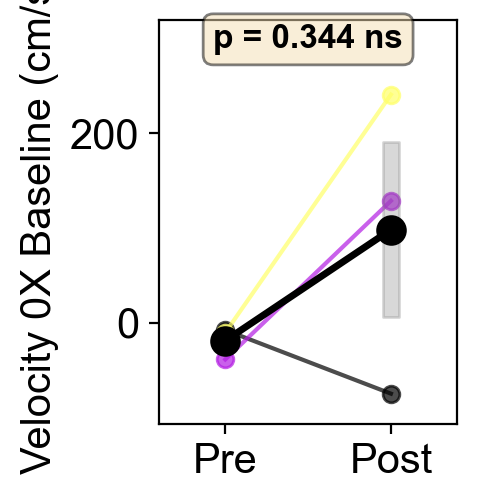

   📊 Cohort CSV paired t-test (Motor_Velocity_Baseline): t=1.7770, p=0.2175, n=3
   ✅ Saved: /Users/nora/Desktop/for_poster/cohort_3/prepost_plots/Motor_Velocity_Baseline_prepost_from_csv.pdf


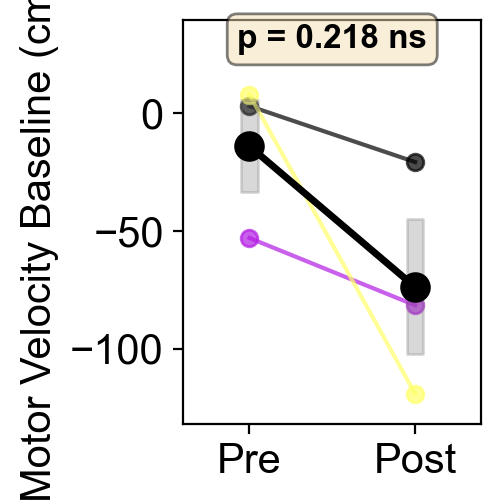

   📊 Cohort CSV paired t-test (z_470_Baseline): t=2.1623, p=0.1631, n=3
   ✅ Saved: /Users/nora/Desktop/for_poster/cohort_3/prepost_plots/z_470_Baseline_prepost_from_csv.pdf


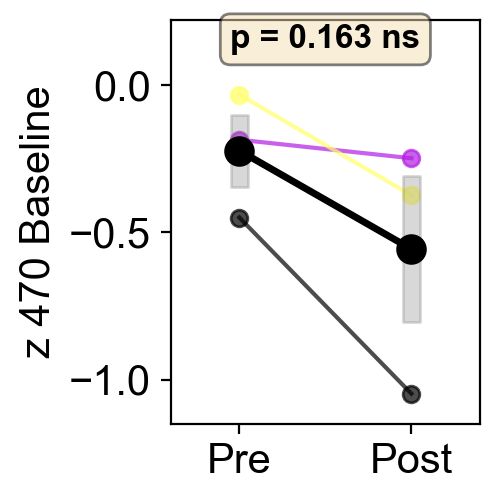

   📊 Cohort CSV paired t-test (z_560_Baseline): t=-12.1127, p=0.0067, n=3
   ✅ Saved: /Users/nora/Desktop/for_poster/cohort_3/prepost_plots/z_560_Baseline_prepost_from_csv.pdf


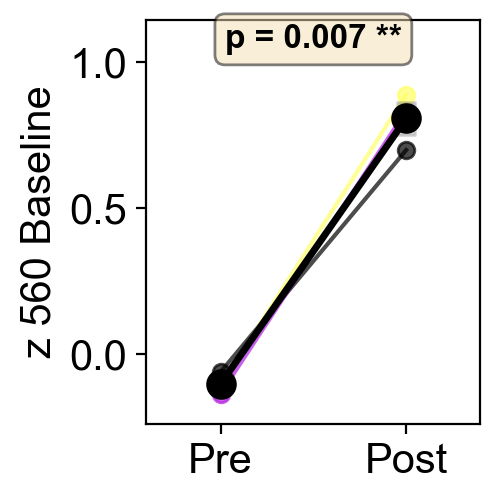

In [25]:
# PRE/POST COMPARISON PLOTS
#---------------------------------------------------------------------------------------------------#

prepost_output_dir = Path(PREPOST_SAVE_DIR).expanduser() if PREPOST_SAVE_DIR else None

if PLOT_PREPOST_FROM_RESULTS and results:
    print(f"\n{'='*60}")
    print("PRE/POST COMPARISON FROM CURRENT RESULTS")
    print(f"{'='*60}")
    plot_prepost_from_results(
        results=results,
        columns_to_plot=columns_to_plot,
        selected_mice=selected_mice,
        pre_time=(-2, 0),
        post_time=(0, 2),
        save_dir=prepost_output_dir,
        main_data_dir=main_data_dir,
    )
else:
    print("⏭️  Skipping pre/post plots from results (flag disabled or no results)")

if LOAD_EXISTING_PREPOST_CSV and EXISTING_PREPOST_CSV_PATH:
    print(f"\n{'='*60}")
    print("PRE/POST COMPARISON FROM EXISTING COHORT CSV")
    print(f"{'='*60}")
    try:
        plot_prepost_from_cohort_csv(
            cohort_csv_path=EXISTING_PREPOST_CSV_PATH,
            columns_to_plot=columns_to_plot,
            selected_mice=selected_mice if selected_mice else None,
            pre_time=(-2, 0),
            post_time=(0, 2),
            save_dir=prepost_output_dir,
        )
    except Exception as exc:
        print(f"⚠️ Error plotting pre/post from existing cohort CSV: {exc}")
else:
    print("⏭️  Skipping pre/post plots from existing CSV (flag disabled or path not set)")

In [26]:
# SAVE GRAND AVERAGES CSV

if results and SAVE_CSV:
    # Create a DataFrame combining grand averages and SEMs
    grand_avg_with_sem = results['grand_averages'].copy()
    for col in results['grand_sems'].columns:
        grand_avg_with_sem[f'{col}_SEM'] = results['grand_sems'][col]
    
    # Generate filename
    csv_filename = main_data_dir / f"grand_averages_with_sem{event_name.replace('.csv', '')}.csv"
    
    # Save the DataFrame to a CSV file
    grand_avg_with_sem.to_csv(csv_filename)
    print(f"✅ Grand averages with SEM saved to: {csv_filename}")
else:
    print("⏭️  Skipping CSV save (SAVE_CSV=False or no results)")

⏭️  Skipping CSV save (SAVE_CSV=False or no results)


In [ ]:
# INTERACTIVE GRAND AVERAGE PLOTTING
#---------------------------------------------------------------------------------------------------#

def find_csv_files(base_paths):
    """Find all grand_averages CSV files in the given paths."""
    csv_files = []
    for base_path in base_paths:
        path = Path(base_path)
        if path.exists():
            # Search in the directory and subdirectories
            for csv_file in path.rglob('grand_averages_with_sem*.csv'):
                csv_files.append(str(csv_file))
    return sorted(csv_files)

def get_available_columns(df):
    """Get available data columns (excluding Time and SEM columns)."""
    # Filter out Time column and SEM columns
    data_cols = [col for col in df.columns 
                 if col != 'Time (s)' and not col.endswith('_SEM')]
    return sorted(data_cols)

def get_column_label(column_name):
    """Generate a readable label for a column."""
    # Map common column names to readable labels
    label_map = {
        'z_470': 'GRAB-5HT3.0 (z-score)',
        'z_470_Baseline': 'GRAB-5HT3.0 (z-score)',
        'z_560': 'RGeco1a (z-score)',
        'z_560_Baseline': 'RGeco1a (z-score)',
        'Velocity_0X': 'Running speed',
        'Velocity_0X_Baseline': 'Running speed',
        'Motor_Velocity': 'Motor Velocity',
        'Motor_Velocity_Baseline': 'Motor Velocity',
    }
    return label_map.get(column_name, column_name)

def get_axis_label(column_name):
    """Generate axis label based on column name."""
    if 'z_' in column_name or 'z-score' in column_name.lower():
        return 'z-score'
    elif 'Velocity' in column_name or 'velocity' in column_name.lower():
        return 'Running speed (m/s)'
    elif 'Motor' in column_name:
        return 'Motor velocity (m/s)'
    else:
        return column_name

def should_use_right_axis(column_name):
    """Determine if a column should be plotted on the right axis."""
    # Velocity and Motor columns go on right axis
    return 'Velocity' in column_name or 'Motor' in column_name

def plot_grand_averages_multi_series(series_list):
    """
    Plot multiple series from different files on the same graph.
    
    Parameters:
    -----------
    series_list : list of dict
        Each dict should have: {'file': file_path, 'column': column_name, 'label': optional_label}
    """
    plt.rcParams.update({
        'font.size': 10,
        'font.family': 'sans-serif',
        'font.sans-serif': ['DejaVu Sans'],
        'axes.titlesize': 10,
        'axes.labelsize': 10,
        'legend.fontsize': 8,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10
    })
    
    if not series_list:
        print("⚠️ No series selected for plotting.")
        return
    
    print(f"📊 Plotting {len(series_list)} series...")
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax2 = None
    
    # Separate series by axis type
    left_axis_series = []
    right_axis_series = []
    
    for idx, series in enumerate(series_list):
        file_path = series['file']
        column = series['column']
        label = series.get('label', None)
        
        print(f"  Series {idx+1}: {Path(file_path).name} - {column}")
        
        if not file_path or not column:
            print(f"    ⚠️ Skipping: missing file_path or column")
            continue
        
        try:
            # Read the CSV file fresh each time (no caching)
            # Use absolute path to ensure we're reading the correct file
            abs_file_path = Path(file_path).resolve()
            print(f"    📁 Reading file: {abs_file_path.name}")
            print(f"    📁 Full path: {abs_file_path}")
            
            df = pd.read_csv(abs_file_path)
            file_label = Path(file_path).parent.name
            
            print(f"    ✅ Loaded file: {len(df)} rows, columns: {list(df.columns)[:5]}...")
            print(f"    📋 All columns: {list(df.columns)}")
            
            if column not in df.columns:
                print(f"    ⚠️ Column {column} not found in {file_path}")
                print(f"    Available columns: {list(df.columns)}")
                continue
            
            # Determine which axis to use
            use_right = should_use_right_axis(column)
            
            # Generate label
            if label:
                plot_label = label
            else:
                col_label = get_column_label(column)
                plot_label = f"{col_label} ({file_label})"
            
            print(f"    📈 Plotting on {'right' if use_right else 'left'} axis: {plot_label}")
            
            # Plot on appropriate axis
            if use_right:
                if ax2 is None:
                    ax2 = ax.twinx()
                ax2.plot(df['Time (s)'], df[column], label=plot_label, 
                         color=series.get('color', 'slategray'), 
                         linestyle=series.get('linestyle', '-'),
                         alpha=1)
                if f'{column}_SEM' in df.columns:
                    ax2.fill_between(df['Time (s)'],
                                    df[column] - df[f'{column}_SEM'],
                                    df[column] + df[f'{column}_SEM'],
                                    color=series.get('color', 'slategray'), alpha=0.2)
                right_axis_series.append(series)
            else:
                ax.plot(df['Time (s)'], df[column], label=plot_label,
                       color=series.get('color', 'green'),
                       linestyle=series.get('linestyle', '-'),
                       alpha=1)
                if f'{column}_SEM' in df.columns:
                    ax.fill_between(df['Time (s)'],
                                   df[column] - df[f'{column}_SEM'],
                                   df[column] + df[f'{column}_SEM'],
                                   color=series.get('color', 'green'), alpha=0.1)
                left_axis_series.append(series)
                
        except Exception as e:
            print(f"    ⚠️ Error loading {file_path}: {e}")
            import traceback
            traceback.print_exc()
            continue
    
    print(f"\n✅ Successfully plotted: {len(left_axis_series)} left axis, {len(right_axis_series)} right axis")
    
    # Set axis labels
    if left_axis_series:
        first_col = left_axis_series[0]['column']
        ax.set_ylabel(get_axis_label(first_col), fontname='DejaVu Sans', fontsize=10, color='black')
        ax.tick_params(axis='y', labelcolor='black')
    
    if right_axis_series and ax2:
        first_col = right_axis_series[0]['column']
        ax2.set_ylabel(get_axis_label(first_col), fontname='DejaVu Sans', fontsize=10, color='slategray')
        ax2.tick_params(axis='y', labelcolor='slategray')
    
    ax.axvspan(0, 2, color='gray', alpha=0.2, label='Visual mismatch (0-2s)')
    ax.set_title('Grand Averages Comparison', fontname='DejaVu Sans', fontsize=12)
    ax.set_xlabel('Time (s)', fontname='DejaVu Sans', fontsize=10)
    
    # Combine legends
    lines, labels = ax.get_legend_handles_labels()
    if ax2:
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax.legend(lines + lines2, labels + labels2, loc='upper right', 
                 prop={'family': 'DejaVu Sans', 'size': 10})
    else:
        ax.legend(lines, labels, loc='upper right', prop={'family': 'DejaVu Sans', 'size': 10})
    
    plt.tight_layout()
    plt.show()
    
    return fig

def plot_grand_averages_single(df, label, y1_col=None, y2_col=None):
    """Plot grand averages from a single CSV file with selected columns."""
    plt.rcParams.update({
        'font.size': 10,
        'font.family': 'sans-serif',
        'font.sans-serif': ['DejaVu Sans'],
        'axes.titlesize': 10,
        'axes.labelsize': 10,
        'legend.fontsize': 8,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10
    })
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax2 = None
    
    # Plot y1 column on left axis
    if y1_col and y1_col in df.columns:
        ax.plot(df['Time (s)'], df[y1_col], label=get_column_label(y1_col), 
                color='green', alpha=1)
        if f'{y1_col}_SEM' in df.columns:
            ax.fill_between(df['Time (s)'],
                           df[y1_col] - df[f'{y1_col}_SEM'],
                           df[y1_col] + df[f'{y1_col}_SEM'],
                           color='green', alpha=0.1)
        ax.set_ylabel(get_axis_label(y1_col), fontname='DejaVu Sans', fontsize=10, color='black')
        ax.tick_params(axis='y', labelcolor='black')
    
    # Plot y2 column on right axis (if different from y1)
    if y2_col and y2_col in df.columns and y2_col != y1_col:
        ax2 = ax.twinx()
        ax2.plot(df['Time (s)'], df[y2_col], label=get_column_label(y2_col), 
                color='slategray', alpha=1)
        if f'{y2_col}_SEM' in df.columns:
            ax2.fill_between(df['Time (s)'],
                            df[y2_col] - df[f'{y2_col}_SEM'],
                            df[y2_col] + df[f'{y2_col}_SEM'],
                            color='slategray', alpha=0.2)
        ax2.set_ylabel(get_axis_label(y2_col), fontname='DejaVu Sans', fontsize=10, color='slategray')
        ax2.tick_params(axis='y', labelcolor='slategray')
    
    ax.axvspan(0, 2, color='gray', alpha=0.2, label='Visual mismatch (0-2s)')
    ax.set_title(f'Grand Averages: {label}', fontname='DejaVu Sans', fontsize=12)
    ax.set_xlabel('Time (s)', fontname='DejaVu Sans', fontsize=10)
    
    # Combine legends
    lines, labels = ax.get_legend_handles_labels()
    if ax2:
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax.legend(lines + lines2, labels + labels2, loc='upper right', 
                 prop={'family': 'DejaVu Sans', 'size': 10})
    else:
        ax.legend(lines, labels, loc='upper right', prop={'family': 'DejaVu Sans', 'size': 10})
    
    plt.tight_layout()
    plt.show()

def plot_grand_averages_comparison(df1, df2, label1, label2, y1_col=None, y2_col=None):
    """Plot grand averages comparing two CSV files with selected columns."""
    plt.rcParams.update({
        'font.size': 10,
        'font.family': 'sans-serif',
        'font.sans-serif': ['DejaVu Sans'],
        'axes.titlesize': 10,
        'axes.labelsize': 10,
        'legend.fontsize': 8,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10
    })
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax2 = None
    
    # Plot y1 column on left axis
    if y1_col:
        if y1_col in df1.columns:
            ax.plot(df1['Time (s)'], df1[y1_col], label=f"{get_column_label(y1_col)} ({label1})", 
                    color='green', alpha=1)
            if f'{y1_col}_SEM' in df1.columns:
                ax.fill_between(df1['Time (s)'],
                               df1[y1_col] - df1[f'{y1_col}_SEM'],
                               df1[y1_col] + df1[f'{y1_col}_SEM'],
                               color='green', alpha=0.1)
        
        if y1_col in df2.columns:
            ax.plot(df2['Time (s)'], df2[y1_col], label=f"{get_column_label(y1_col)} ({label2})", 
                    color='orange', alpha=1, linestyle='--')
            if f'{y1_col}_SEM' in df2.columns:
                ax.fill_between(df2['Time (s)'],
                               df2[y1_col] - df2[f'{y1_col}_SEM'],
                               df2[y1_col] + df2[f'{y1_col}_SEM'],
                               color='orange', alpha=0.1)
        
        ax.set_ylabel(get_axis_label(y1_col), fontname='DejaVu Sans', fontsize=10, color='black')
        ax.tick_params(axis='y', labelcolor='black')
    
    # Plot y2 column on right axis (if different from y1)
    if y2_col and y2_col != y1_col:
        ax2 = ax.twinx()
        
        if y2_col in df1.columns:
            ax2.plot(df1['Time (s)'], df1[y2_col], label=f"{get_column_label(y2_col)} ({label1})", 
                    color='slategray', alpha=1)
            if f'{y2_col}_SEM' in df1.columns:
                ax2.fill_between(df1['Time (s)'],
                                df1[y2_col] - df1[f'{y2_col}_SEM'],
                                df1[y2_col] + df1[f'{y2_col}_SEM'],
                                color='slategray', alpha=0.2)
        
        if y2_col in df2.columns:
            ax2.plot(df2['Time (s)'], df2[y2_col], label=f"{get_column_label(y2_col)} ({label2})", 
                    color='slategray', alpha=1, linestyle='--')
            if f'{y2_col}_SEM' in df2.columns:
                ax2.fill_between(df2['Time (s)'],
                                df2[y2_col] - df2[f'{y2_col}_SEM'],
                                df2[y2_col] + df2[f'{y2_col}_SEM'],
                                color='slategray', alpha=0.2)
        
        ax2.set_ylabel(get_axis_label(y2_col), fontname='DejaVu Sans', fontsize=10, color='slategray')
        ax2.tick_params(axis='y', labelcolor='slategray')
    
    ax.axvspan(0, 2, color='gray', alpha=0.2, label='Visual mismatch (0-2s)')
    ax.set_title('Grand Averages with SEM', fontname='DejaVu Sans', fontsize=12)
    ax.set_xlabel('Time (s)', fontname='DejaVu Sans', fontsize=10)
    
    # Combine legends
    lines, labels = ax.get_legend_handles_labels()
    if ax2:
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax.legend(lines + lines2, labels + labels2, loc='upper right', 
                 prop={'family': 'DejaVu Sans', 'size': 10})
    else:
        ax.legend(lines, labels, loc='upper right', prop={'family': 'DejaVu Sans', 'size': 10})
    
    plt.tight_layout()
    plt.show()

def plot_grand_averages_interactive():
    """Create interactive plot with dropdowns for multiple CSV file and column selection."""
    
    # Find available CSV files using the same paths as DATA_DIRS
    base_paths = DATA_DIRS if DATA_DIRS else []
    
    csv_files = find_csv_files(base_paths)
    
    if not csv_files:
        print("⚠️ No CSV files found. Please check your paths.")
        return
    
    if WIDGETS_AVAILABLE:
        # Store series widgets
        series_widgets = []
        series_container = widgets.VBox([])
        
        # Store current figure for saving
        current_fig = [None]  # Use list to allow modification in nested functions
        
        # Color options for different series
        color_options = ['green', 'blue', 'red', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
        linestyle_options = ['-', '--', '-.', ':']
        
        def create_series_row(series_id):
            """Create a row of widgets for selecting file and column."""
            file_dropdown = widgets.Dropdown(
                options=['None'] + csv_files,
                value='None',
                description=f'File {series_id}:',
                style={'description_width': 'initial'},
                layout=widgets.Layout(width='400px')
            )
            
            col_dropdown = widgets.Dropdown(
                options=[''],
                value='',
                description='Column:',
                style={'description_width': 'initial'},
                layout=widgets.Layout(width='250px')
            )
            
            remove_btn = widgets.Button(
                description='Remove',
                button_style='danger',
                layout=widgets.Layout(width='80px', height='30px')
            )
            
            def update_columns(change):
                """Update column dropdown when file changes."""
                if change['new'] and change['new'] != 'None':
                    try:
                        # Clear the current column value first
                        col_dropdown.value = ''
                        
                        # Read the new file
                        df = pd.read_csv(change['new'])
                        available_cols = get_available_columns(df)
                        
                        # Update options and set to first available column
                        col_dropdown.options = available_cols
                        if available_cols:
                            col_dropdown.value = available_cols[0]
                        else:
                            col_dropdown.value = ''
                        
                        # Debug output
                        print(f"📁 File changed to: {Path(change['new']).name}")
                        print(f"   Available columns: {available_cols[:5]}..." if len(available_cols) > 5 else f"   Available columns: {available_cols}")
                        print(f"   Selected column: {col_dropdown.value}")
                    except Exception as e:
                        print(f"⚠️ Error loading file: {e}")
                        import traceback
                        traceback.print_exc()
                        col_dropdown.options = ['']
                        col_dropdown.value = ''
                else:
                    col_dropdown.options = ['']
                    col_dropdown.value = ''
            
            def remove_series(b):
                """Remove this series row."""
                for i, (f, c, r, _) in enumerate(series_widgets):
                    if f == file_dropdown:
                        series_widgets.pop(i)
                        update_series_display()
                        break
            
            file_dropdown.observe(update_columns, names='value')
            remove_btn.on_click(remove_series)
            
            return file_dropdown, col_dropdown, remove_btn, widgets.HBox([file_dropdown, col_dropdown, remove_btn])
        
        def update_series_display():
            """Update the display of all series rows."""
            children = [row[3] for row in series_widgets]
            series_container.children = children
        
        def add_series(b):
            """Add a new series row."""
            series_id = len(series_widgets) + 1
            widgets_row = create_series_row(series_id)
            series_widgets.append(widgets_row)
            update_series_display()
        
        def plot_all_series(b):
            """Plot all selected series."""
            with output:
                clear_output(wait=True)
                series_list = []
                
                for file_dropdown, col_dropdown, _, _ in series_widgets:
                    file_path = file_dropdown.value
                    column = col_dropdown.value
                    
                    # Debug: print what we're checking
                    print(f"Checking: file_path={file_path}, column={column}")
                    
                    # Check if both file and column are valid
                    if file_path and file_path != 'None' and column and column != '':
                        series_list.append({
                            'file': file_path,
                            'column': column,
                            'color': color_options[len(series_list) % len(color_options)],
                            'linestyle': linestyle_options[(len(series_list) // len(color_options)) % len(linestyle_options)]
                        })
                        print(f"✅ Added series: {Path(file_path).name} - {column}")
                    else:
                        print(f"⏭️ Skipped: file_path={file_path}, column={column}")
                
                print(f"\n📊 Total series to plot: {len(series_list)}")
                
                if not series_list:
                    print("⚠️ Please select at least one file and column combination.")
                    return
                
                try:
                    fig = plot_grand_averages_multi_series(series_list)
                    current_fig[0] = fig  # Store figure for saving
                except Exception as e:
                    print(f"⚠️ Error plotting: {e}")
                    import traceback
                    traceback.print_exc()
        
        def save_current_plot(b):
            """Save the current plot to a file."""
            if current_fig[0] is None:
                with output:
                    print("⚠️ No plot to save. Please plot first.")
                return
            
            # Generate filename based on selected series
            series_names = []
            first_file_path = None
            
            for file_dropdown, col_dropdown, _, _ in series_widgets:
                file_path = file_dropdown.value
                column = col_dropdown.value
                if file_path and file_path != 'None' and column and column != '':
                    if first_file_path is None:
                        first_file_path = file_path
                    file_label = Path(file_path).parent.name
                    series_names.append(f"{file_label}_{column}")
            
            if series_names:
                filename_base = "_vs_".join(series_names[:3])  # Limit filename length
                if len(series_names) > 3:
                    filename_base += f"_and_{len(series_names)-3}_more"
            else:
                filename_base = "grand_averages_plot"
            
            # Get save directory from the first CSV file being plotted
            if first_file_path:
                save_dir = Path(first_file_path).parent
            else:
                save_dir = Path(DATA_DIRS[0]) if DATA_DIRS else Path.cwd()
            
            # Save as PDF and PNG
            pdf_path = save_dir / f"{filename_base}.pdf"
            png_path = save_dir / f"{filename_base}.png"
            
            try:
                current_fig[0].savefig(pdf_path, dpi=300, bbox_inches='tight')
                current_fig[0].savefig(png_path, dpi=300, bbox_inches='tight')
                with output:
                    print(f"✅ Plot saved to:")
                    print(f"   PDF: {pdf_path}")
                    print(f"   PNG: {png_path}")
            except Exception as e:
                with output:
                    print(f"⚠️ Error saving plot: {e}")
                    import traceback
                    traceback.print_exc()
        
        # Create initial series row
        add_series(None)
        
        # Buttons
        add_btn = widgets.Button(
            description='+ Add Series',
            button_style='info',
            layout=widgets.Layout(width='150px')
        )
        add_btn.on_click(add_series)
        
        plot_button = widgets.Button(
            description='Plot All Series',
            button_style='success',
            layout=widgets.Layout(width='200px')
        )
        plot_button.on_click(plot_all_series)
        
        save_button = widgets.Button(
            description='Save Plot',
            button_style='warning',
            layout=widgets.Layout(width='150px')
        )
        save_button.on_click(save_current_plot)
        
        output = widgets.Output()
        
        display(widgets.VBox([
            widgets.HTML("<h3>Select multiple files and columns to plot:</h3>"),
            widgets.HTML("<p><i>Add multiple series to compare columns from different files on the same graph.</i></p>"),
            series_container,
            widgets.HBox([add_btn, plot_button, save_button]),
            output
        ]))
    else:
        # Fallback: manual selection
        print("Available CSV files:")
        for i, f in enumerate(csv_files, 1):
            print(f"{i}. {f}")
        print("\n⚠️ ipywidgets not available. Please manually set file paths below.")
        return csv_files

# Run interactive plotting
plot_grand_averages_interactive()

In [ ]:
# #---------------------------------------------------------------------------------------------------#
# # CORRELATION ANALYSIS
# #---------------------------------------------------------------------------------------------------#
# # This section performs correlation analysis between Velocity and z-scores (z_470, z_560)
# # Requires loading previously saved results from pickle files for multiple cohorts

# #---------------------------------------------------------------------------------------------------#
# # Helper Functions
# #---------------------------------------------------------------------------------------------------#

# def load_results(filename):
#     """Load results from a pickle file."""
#     with open(filename, 'rb') as f:
#         return pickle.load(f)

# def fisher_z(r):
#     """Convert correlation coefficient to Fisher's z."""
#     return 0.5 * np.log((1 + r) / (1 - r))

# def compare_correlations(r1, n1, r2, n2):
#     """Compare two correlation coefficients using Fisher's z transformation."""
#     z1 = fisher_z(r1)
#     z2 = fisher_z(r2)
#     se = np.sqrt(1 / (n1 - 3) + 1 / (n2 - 3))
#     z = (z1 - z2) / se
#     p = 2 * (1 - norm.cdf(abs(z)))
#     return z, p

# def extract_means(results, mice, time_window, columns=columns_to_plot):
#     """
#     Extract mean values for specified columns within a given time window for a list of mice.

#     Parameters:
#     results (dict): Dictionary containing data for each mouse.
#     mice (list): List of mouse names to extract data for.
#     time_window (tuple): Time window (start, end) for extracting mean values.
#     columns (list): List of column names to extract.

#     Returns:
#     tuple: Mean values for Velocity_0X, z_470, z_560, and valid mouse names.
#     """
#     v_means, z470_means, z560_means, valid_mice = [], [], [], []
#     t0, t1 = time_window

#     for mouse in mice:
#         if mouse not in results['mean_data_per_mouse']:
#             continue
#         df = results['mean_data_per_mouse'][mouse]
#         if not all(col in df.columns for col in columns):
#             continue

#         df_window = df.loc[(df.index >= t0) & (df.index <= t1)]
#         v = df_window[columns[0]].mean()
#         z470 = df_window[columns[1]].mean()
#         z560 = df_window[columns[2]].mean()

#         if not any(pd.isnull([v, z470, z560])):
#             v_means.append(v)
#             z470_means.append(z470)
#             z560_means.append(z560)
#             valid_mice.append(mouse)

#     return v_means, z470_means, z560_means, valid_mice

# def move_mouse_data_fixed(v1, z470_1, z560_1, ids1, v2, z470_2, z560_2, ids2, 
#                          target_mouse, exclude_mice):
#     """
#     Fixed version that maintains array consistency when moving mouse data between cohorts.
#     """
#     # Convert to lists if not already (for easier manipulation)
#     v1, z470_1, z560_1, ids1 = list(v1), list(z470_1), list(z560_1), list(ids1)
#     v2, z470_2, z560_2, ids2 = list(v2), list(z470_2), list(z560_2), list(ids2)
    
#     # Exclude mice from both cohorts
#     for mouse in exclude_mice:
#         # Remove from cohort 1
#         while mouse in ids1:
#             idx = ids1.index(mouse)
#             del v1[idx], z470_1[idx], z560_1[idx], ids1[idx]
        
#         # Remove from cohort 2
#         while mouse in ids2:
#             idx = ids2.index(mouse)
#             del v2[idx], z470_2[idx], z560_2[idx], ids2[idx]
    
#     # Move target mouse data
#     if target_mouse in ids2:
#         idx = ids2.index(target_mouse)
        
#         # Store the data to move
#         target_v = v2[idx]
#         target_z470 = z470_2[idx]
#         target_z560 = z560_2[idx]
        
#         # Remove original entry from Cohort 2
#         del v2[idx], z470_2[idx], z560_2[idx], ids2[idx]
        
#         # Add to Cohort 1 (velocity and z_470, NaN for z_560)
#         v1.append(target_v)
#         z470_1.append(target_z470)
#         z560_1.append(np.nan)
#         ids1.append(target_mouse + " (from Cohort 2)")
        
#         # Keep z_560 correlation in Cohort 2 (velocity and z_560, NaN for z_470)
#         v2.append(target_v)
#         z470_2.append(np.nan)
#         z560_2.append(target_z560)
#         ids2.append(target_mouse + " (z_560)")
        
#         print(f"✅ Moved velocity & z_470 of {target_mouse} to Cohort 1.")
#         print(f"✅ Retained velocity & z_560 of {target_mouse} in Cohort 2.")
#     else:
#         print(f"⚠️ Mouse {target_mouse} not found in Cohort 2.")
    
#     return v1, z470_1, z560_1, ids1, v2, z470_2, z560_2, ids2

# def analyze_correlations_from_data_fixed(
#     v1, z470_1, z560_1, ids1,
#     v2, z470_2, z560_2, ids2,
#     time_window=None,
#     plot=True
# ):
#     """
#     Fixed correlation analysis function that computes correlations and compares them.
#     """
#     def filter_valid_pairs(x, y, labels):
#         x = np.array(x)
#         y = np.array(y)
#         labels = np.array(labels)
        
#         # Ensure all arrays have the same length
#         min_len = min(len(x), len(y), len(labels))
#         x = x[:min_len]
#         y = y[:min_len]
#         labels = labels[:min_len]
        
#         # Filter out NaN values
#         mask = ~np.isnan(x) & ~np.isnan(y)
#         return x[mask], y[mask], labels[mask]

#     if time_window is None:
#         time_window = (0, 2)  # Default time window if not specified

#     # Filter valid pairs for each correlation
#     v1_470, z470_1_filt, ids1_470 = filter_valid_pairs(v1, z470_1, ids1)
#     v1_560, z560_1_filt, ids1_560 = filter_valid_pairs(v1, z560_1, ids1)
#     v2_470, z470_2_filt, ids2_470 = filter_valid_pairs(v2, z470_2, ids2)
#     v2_560, z560_2_filt, ids2_560 = filter_valid_pairs(v2, z560_2, ids2)

#     # Calculate correlations
#     results = {}
#     if len(v1_470) > 1:
#         corr1_470, p1_470 = pearsonr(v1_470, z470_1_filt)
#         results['corr1_470'] = (corr1_470, p1_470, len(v1_470))
#     else:
#         results['corr1_470'] = (np.nan, np.nan, len(v1_470))
        
#     if len(v1_560) > 1:
#         corr1_560, p1_560 = pearsonr(v1_560, z560_1_filt)
#         results['corr1_560'] = (corr1_560, p1_560, len(v1_560))
#     else:
#         results['corr1_560'] = (np.nan, np.nan, len(v1_560))
        
#     if len(v2_470) > 1:
#         corr2_470, p2_470 = pearsonr(v2_470, z470_2_filt)
#         results['corr2_470'] = (corr2_470, p2_470, len(v2_470))
#     else:
#         results['corr2_470'] = (np.nan, np.nan, len(v2_470))
        
#     if len(v2_560) > 1:
#         corr2_560, p2_560 = pearsonr(v2_560, z560_2_filt)
#         results['corr2_560'] = (corr2_560, p2_560, len(v2_560))
#     else:
#         results['corr2_560'] = (np.nan, np.nan, len(v2_560))

#     # Print results
#     print("\n📊 Correlations:")
#     print(f"Cohort 1: Velocity ~ z_470: r = {results['corr1_470'][0]:.3f}, p = {results['corr1_470'][1]:.3f} (n={results['corr1_470'][2]})")
#     print(f"Cohort 1: Velocity ~ z_560: r = {results['corr1_560'][0]:.3f}, p = {results['corr1_560'][1]:.3f} (n={results['corr1_560'][2]})")
#     print(f"Cohort 2: Velocity ~ z_470: r = {results['corr2_470'][0]:.3f}, p = {results['corr2_470'][1]:.3f} (n={results['corr2_470'][2]})")
#     print(f"Cohort 2: Velocity ~ z_560: r = {results['corr2_560'][0]:.3f}, p = {results['corr2_560'][1]:.3f} (n={results['corr2_560'][2]})")

#     # Compare correlations
#     if results['corr1_470'][2] > 3 and results['corr2_470'][2] > 3:
#         z_470, p_470 = compare_correlations(results['corr1_470'][0], results['corr1_470'][2], 
#                                           results['corr2_470'][0], results['corr2_470'][2])
#         print(f"\n🔍 Comparison of correlations for z_470:")
#         print(f"z = {z_470:.3f}, p = {p_470:.3f}")
#     else:
#         print("⚠️ Not enough data to compare z_470 correlations.")

#     if results['corr1_560'][2] > 3 and results['corr2_560'][2] > 3:
#         z_560, p_560 = compare_correlations(results['corr1_560'][0], results['corr1_560'][2], 
#                                           results['corr2_560'][0], results['corr2_560'][2])
#         print(f"\n🔍 Comparison of correlations for z_560:")
#         print(f"z = {z_560:.3f}, p = {p_560:.3f}")
#     else:
#         print("⚠️ Not enough data to compare z_560 correlations.")

#     # Create plots
#     if plot:
#         # Plot properties
#         plt.rcParams.update({
#             'font.size': 10,
#             'font.family': 'sans-serif',
#             'font.sans-serif': ['DejaVu Sans'],
#             'axes.titlesize': 10,
#             'axes.labelsize': 10,
#             'legend.fontsize': 8,
#             'xtick.labelsize': 10,
#             'ytick.labelsize': 10
#         })
        
#         fig, axs = plt.subplots(1, 2, figsize=(12, 5))
#         t_str = f"{time_window[0]} to {time_window[1]}s"

#         # Plot z_470 correlations
#         if len(v1_470) > 0:
#             axs[0].scatter(v1_470, z470_1_filt, color='green', label=f'Cohort 1 (n={len(v1_470)})', alpha=0.7)
#             for i, mouse in enumerate(ids1_470):
#                 axs[0].text(v1_470[i], z470_1_filt[i], mouse, fontsize=6, color='green', alpha=0.6)
#             if len(v1_470) > 1:
#                 m1, b1 = np.polyfit(v1_470, z470_1_filt, 1)
#                 x_range = np.linspace(min(v1_470), max(v1_470), 100)
#                 axs[0].plot(x_range, m1 * x_range + b1, color='green', linestyle='--', alpha=0.8)
        
#         if len(v2_470) > 0:
#             axs[0].scatter(v2_470, z470_2_filt, color='orange', label=f'Cohort 2 (n={len(v2_470)})', alpha=0.7)
#             for i, mouse in enumerate(ids2_470):
#                 axs[0].text(v2_470[i], z470_2_filt[i], mouse, fontsize=6, color='orange', alpha=0.6)
#             if len(v2_470) > 1:
#                 m2, b2 = np.polyfit(v2_470, z470_2_filt, 1)
#                 x_range = np.linspace(min(v2_470), max(v2_470), 100)
#                 axs[0].plot(x_range, m2 * x_range + b2, color='orange', linestyle='--', alpha=0.8)
        
#         axs[0].set_title(f'Velocity vs z_470\n({t_str})')
#         axs[0].set_xlabel('Mean Velocity_0X (m/s)')
#         axs[0].set_ylabel('Mean z-score (470nm)')
#         axs[0].legend()
#         axs[0].grid(True, alpha=0.3)

#         # Plot z_560 correlations
#         if len(v1_560) > 0:
#             axs[1].scatter(v1_560, z560_1_filt, color='red', label=f'Cohort 1 (n={len(v1_560)})', alpha=0.7)
#             for i, mouse in enumerate(ids1_560):
#                 axs[1].text(v1_560[i], z560_1_filt[i], mouse, fontsize=6, color='red', alpha=0.6)
#             if len(v1_560) > 1:
#                 m1, b1 = np.polyfit(v1_560, z560_1_filt, 1)
#                 x_range = np.linspace(min(v1_560), max(v1_560), 100)
#                 axs[1].plot(x_range, m1 * x_range + b1, color='red', linestyle='--', alpha=0.8)
        
#         if len(v2_560) > 0:
#             axs[1].scatter(v2_560, z560_2_filt, color='darkred', label=f'Cohort 2 (n={len(v2_560)})', alpha=0.7)
#             for i, mouse in enumerate(ids2_560):
#                 axs[1].text(v2_560[i], z560_2_filt[i], mouse, fontsize=6, color='darkred', alpha=0.6)
#             if len(v2_560) > 1:
#                 m2, b2 = np.polyfit(v2_560, z560_2_filt, 1)
#                 x_range = np.linspace(min(v2_560), max(v2_560), 100)
#                 axs[1].plot(x_range, m2 * x_range + b2, color='darkred', linestyle='--', alpha=0.8)
        
#         axs[1].set_title(f'Velocity vs z_560\n({t_str})')
#         axs[1].set_xlabel('Mean Velocity_0X (m/s)')
#         axs[1].set_ylabel('Mean z-score (560nm)')
#         axs[1].legend()
#         axs[1].grid(True, alpha=0.3)

#         plt.tight_layout()
#         plt.show()
    
#     return results

# #---------------------------------------------------------------------------------------------------#
# # Load Data and Run Analysis
# #---------------------------------------------------------------------------------------------------#
# # Uncomment and modify paths as needed for correlation analysis
# # Example:
# # results_cohort1 = load_results('/path/to/Cohort1_results.pkl')
# # results_cohort2 = load_results('/path/to/Cohort2_results.pkl')
# # selected_mice1 = ['B6J2717', 'B6J2718', 'B6J2719', 'B6J2721', 'B6J2722']
# # selected_mice2 = ['B6J2780', 'B6J2781', 'B6J2783', 'B6J2782']
# # time_window = (0, 2)

# # Extract means for each cohort
# # v1, z470_1, z560_1, ids1 = extract_means(results_cohort1, selected_mice1, time_window)
# # v2, z470_2, z560_2, ids2 = extract_means(results_cohort2, selected_mice2, time_window)

# # Optional: Move mouse data between cohorts
# # target_mouse = "B6J2782"  # Specify the mouse to move
# # exclude_mice = ["B6J2722"]  # List of mice to exclude
# # v1, z470_1, z560_1, ids1, v2, z470_2, z560_2, ids2 = move_mouse_data_fixed(
# #     v1, z470_1, z560_1, ids1, v2, z470_2, z560_2, ids2, target_mouse, exclude_mice
# # )

# # Run correlation analysis
# # correlation_results = analyze_correlations_from_data_fixed(
# #     v1, z470_1, z560_1, ids1,
# #     v2, z470_2, z560_2, ids2,
# #     time_window=time_window,
# #     plot=True
# # )